## Easy Atlas Data Analysis with SQL (DuckDB)

Say, which one of these two code snippets do you find more intelligible?


1. Pandas Dataframe:

```python

filtered_df = df[df['rdata'].str.match(r'b\d-[A-Za-z]{3}', na=False)]

result = filtered_df.groupby('rdata').agg({'rt': 'mean', 'rdata': 'size'}).rename(columns={'rdata': 'responses'}).reset_index()
```

2. DuckDB syntax

```python
res=con.sql('''
select rdata,avg(rt),count(1) as responses from atlas where 
    rdata ~ 'b[0-9]-[A-Za-z]{3}'
    AND rdata IS NOT NULL
    group by rdata
''')
```

If you like better SQL and are  often confused or irritated by `pandas` dataframe syntax, __suffer no more__. 

You can use SQL instead without any DB server. On a `Jupyter` Notebook.
And it's fast.

We showcase here [duckdb](https://duckdb.org/), an open-source tool  which can be used for Atlas measurement analysis (or any data analysis).

DuckDB is:
   * Fully integrated with pandas (so you can import and export from and to)
   * Allows SQL execution on data 
   * An in-memory database
   * Severless 
   * Open-source 
   * More info: https://duckdb.org/docs/api/python/overview
   


## Goals of This Post

1. Demonstrate how to use `duckdb` as an alternative to Pandas for data analysis, featuring public Atlas data.
2. Compare the syntax of `duckdb` with that of Pandas through simple examples.
3. Provide helpful starting points for beginners exploring Atlas datasets.

**Disclaimer**: All analysis in [this peer-reviewed ACM CCS paper](https://www.sidnlabs.nl/downloads/6IIRiSdlv0HAd3czcP2Hb0/55682dd97151fb94fda47bdbd773c613/Characterizing_and_Mitigating_Phishing_Attacks_at_ccTLD__peer_reviewed_.pdf) was conducted using `duckdb`. This study was a collaboration among .nl, .be, and .ie.  
   * Maarten Boostels, one of the paper's co-authors, introduced me to `duckdb`.
   * Since then, I’ve become an avid user.


## Pandas vs Duckdb






## Part 1: Data preparation

In [1]:
#setting the measurements we will analyze

#b-root atlas measrurements, `chaos queries`, 15min 
# see more on https://www.isi.edu/~johnh/PAPERS/Moura16b.pdf for more on these measurements

b_root_measurements="https://atlas.ripe.net/api/v2/measurements/10310/results/?start=1730025000&stop=1730025900&format=json"

#Altas probes metadata, daily compiled
probes_file="https://ftp.ripe.net/ripe/atlas/probes/archive/2024/10/20241027.json.bz2"

In [2]:
#import python libraries
import pandas as pd
import json
import duckdb
import requests
import bz2
from io import BytesIO 

## Part 1a: Import Atlas Measurements

In [3]:
b_root=requests.get(b_root_measurements)

In [4]:
b_root_data=b_root.json()

In [5]:
#sample data
b_root_data[0]

{'fw': 4790,
 'lts': 8,
 'dst_addr': '170.247.170.2',
 'af': 4,
 'src_addr': '192.168.178.26',
 'proto': 'UDP',
 'result': {'rt': 22.052,
  'size': 50,
  'abuf': 'aVeAAAABAAEAAAAACGhvc3RuYW1lBGJpbmQAABAAA8AMABAAAwAAAAAABwZiMS1hbXM=',
  'ID': 26967,
  'ANCOUNT': 1,
  'QDCOUNT': 1,
  'NSCOUNT': 0,
  'ARCOUNT': 0,
  'answers': [{'TYPE': 'TXT', 'NAME': 'hostname.bind', 'RDATA': ['b1-ams']}]},
 'msm_id': 10310,
 'prb_id': 1,
 'timestamp': 1730025017,
 'msm_name': 'Tdig',
 'from': '45.138.229.91',
 'type': 'dns',
 'stored_timestamp': 1730025074}

In [6]:
# define a method to parse the data from the JSON file
# so we can add to a list and later import into a dataframe and a duckdb table

def extract_info(data):
    prb_id = data.get('prb_id')
    timestamp = data.get('timestamp')
    src_addr = data.get('src_addr')
    rt = data.get('result', {}).get('rt')
    answers = data.get('result', {}).get('answers', [{}])
    
    # Ensure 'answers' is a non-empty list and 'RDATA' is in the first item
    rdata = None
    if answers and 'RDATA' in answers[0]:
        rdata = answers[0]['RDATA'][0] if answers[0]['RDATA'] else 'None'

    return {
        'prb_id': prb_id,
        'timestamp': timestamp,
        'src_addr': src_addr,
        'rt': rt,
        'rdata': rdata
        
    }
    

In [7]:
data=[]
for k in b_root_data:
    data.append(extract_info(k))

In [8]:
print('We have retrieved ', len(data), ' measurements from Ripe Atlas')

We have retrieved  45880  measurements from Ripe Atlas


In [9]:
# now let's import it to a df
df = pd.DataFrame(data)


In [10]:
#create a new database
con=duckdb.connect('ripe')
# Drop the table if it exists, then create a new one and insert the DataFrame
con.execute("DROP TABLE IF EXISTS atlas")
con.execute("CREATE TABLE atlas (prb_id INTEGER, timestamp INTEGER, src_addr TEXT, rt DOUBLE, rdata TEXT)")
con.execute("INSERT INTO atlas SELECT * FROM df")

result = con.sql("SELECT count(1) AS row_count FROM atlas").fetchone()

# Get the row count
row_count = result[0]




In [11]:
## Sanity check
print("dataset len is:", len(data))
print("df len is", len(df))
print('duckdb table len is',row_count)

dataset len is: 45880
df len is 45880
duckdb table len is 45880


## Part 1b:  importing Atlas Probes metadata

In [12]:
#let's create a probe list to create later a dataframe and a new table
## now we're going to download the probes metadata file
#ok, let's now get the probes metadata
# Download the file
response = requests.get(probes_file)
compressed_data = BytesIO(response.content)

# Decompress the data in memory
with bz2.BZ2File(compressed_data, 'rb') as file:
    probes = json.load(file)

#print sample data
print(probes['objects'][0])
    

pr_list=[]

for k in probes['objects']:
    pr_list.append(k)
    
#pandas df of probes
df_prb=pd.DataFrame(pr_list)

# now let's create  a duckdb table
# yeah, we use pandas for it :)

# Create a table and insert the DataFrame
con.execute("DROP TABLE IF EXISTS df_prb")
con.execute("CREATE TABLE IF NOT EXISTS probes AS SELECT * FROM df_prb")

# Verify the data in the DuckDB table
test_query =  con.sql("SELECT count(1) AS row_count FROM probes").fetchone()

# Get the row count
row_count_probes = test_query[0]

{'id': 1, 'address_v4': '45.138.229.91', 'address_v6': '2a10:3781:e22:1:220:4aff:fec8:23d7', 'asn_v4': 206238, 'asn_v6': 206238, 'prefix_v4': '45.138.228.0/22', 'prefix_v6': '2a10:3780::/29', 'is_anchor': False, 'is_public': True, 'status': 1, 'status_since': 1728711336, 'first_connected': 1288367583, 'total_uptime': 428217106, 'tags': ['dsl', 'home', 'nat', 'native-ipv6', 'ipv6', 'system-v1', 'system-ipv6-capable', 'system-ipv4-rfc1918', 'xs4all', 'system-ipv4-stable-1d', 'system-ipv4-works', 'system-ipv6-works', 'system-resolves-a-correctly', 'system-resolves-aaaa-correctly', 'system-ipv4-capable', 'system-ipv4-stable-30d'], 'country_code': 'NL', 'latitude': 52.3475, 'longitude': 4.9275, 'day': '20241027', 'probe': 'https://atlas.ripe.net/api/v2/probes/1/', 'status_name': 'Connected'}


In [13]:
#sanity check

print("dataset len is:", len(probes['objects']))
print("df_prb len is", len(df_prb))
print('duckdb table len is',row_count_probes)

dataset len is: 42365
df_prb len is 42365
duckdb table len is 42365


## Part 2: Data analysis

OK, so now we have two the same datasets (ripe atlas measurements and probes metadatata) stored in two different ways:
  * Pandas dataframes:
      * Measurements= `df`
      * probes's metadata= `df_prb`
  * Duckdb tables:
      * Measurements= `atlas`
      * probes's metadata= `probes`
  
Let's see how we can perform the same operations on both:

In [14]:
# let's start with how many queries we have
# let's compute the average RTT to each of the anycast server of b-root
# each site (each serfver location) is identified by the rdata field

# option 1: pandas

# Compute average rt for each rdata
average_rt = df.groupby('rdata')['rt'].mean().reset_index()

print(average_rt)



                                   rdata          rt
0                                   DNS1    0.724500
1                                   DNS2    2.280000
2                                   DNS3    1.031000
3                          DNS_AF_NH3_01    4.687000
4                          DNS_AF_NH3_13    4.401000
5                          DNS_AF_NH3_15    4.119000
6                          DNS_AF_NTH_16    4.109000
7                                    NS1    1.195000
8                     OPNsense.local.lan    1.421500
9                    OPNsense.stuyts.com    0.464750
10                    OPNsense.zunie.lan    0.467750
11                           alliance-45    1.789000
12                                     b   65.556000
13                                b1-ams   36.874086
14                                b1-iad   53.347860
15                                b1-lax  122.322482
16                                b1-mia  127.123686
17                                b1-scl   25.

### Deadling with bogus data

As shown above, there are many results, but let's filtered out the valid ones.
   * (Some DNS queires from Ripe Atlas clients are intercepted and hijacked, see [Moura16b](https://ant.isi.edu/~johnh/PAPERS/Moura16a.pdf) and [Nosyk23a](https://pure.tudelft.nl/ws/portalfiles/portal/151232870/978_3_031_28486_1_19.pdf) about it)
   
This means we need to filter out the data.

We can do it by looking at the `rdata` strings. For [B-ROOT](https://b.root-servers.org/), it has the follow format:
   *  bn-ABC , where `n` is a integer and `ABC` is a three letter string, denoting Airport Code
   
 
So let's see how can we do this filtering in both Pandas and Duckdb
   


In [15]:
# Filter rows where rdata matches the pattern bn-ABC
filtered_df = df[df['rdata'].str.match(r'b\d-[A-Za-z]{3}', na=False)]

# Compute average rt and count for each rdata
result = filtered_df.groupby('rdata').agg({'rt': 'mean', 'rdata': 'size'}).rename(columns={'rdata': 'responses'}).reset_index()

print(result)


     rdata          rt  responses
0   b1-ams   36.874086       9631
1   b1-iad   53.347860       1645
2   b1-lax  122.322482        465
3   b1-mia  127.123686        497
4   b1-scl   25.029500         60
5   b1-sin   70.794972        776
6   b2-iad   54.859029       1717
7   b2-lax  109.025563        467
8   b2-mia  127.239884        524
9   b2-scl   25.383507        144
10  b2-sin   72.801364        758
11  b3-ams   35.813374       9645
12  b3-iad   58.851777       1961
13  b3-lax  113.773521        484
14  b3-mia  114.486817        491
15  b3-scl   20.429663         83
16  b3-sin   79.691088        735
17  b4-ams   36.655506       9587
18  b4-iad   51.383624       1848
19  b4-lax  118.284348        443
20  b4-mia  135.760622        556
21  b4-sin   78.695698        884


In [16]:
#Ok, so how would you do it in duckdb
res=con.sql('''
select rdata,avg(rt),count(1) as responses from atlas where 
    rdata ~ 'b[0-9]-[A-Za-z]{3}'
    AND rdata IS NOT NULL
    group by rdata
''')

print(res)


┌─────────┬────────────────────┬───────────┐
│  rdata  │      avg(rt)       │ responses │
│ varchar │       double       │   int64   │
├─────────┼────────────────────┼───────────┤
│ b1-ams  │  36.87408607621223 │      9631 │
│ b4-iad  │  51.38362391774899 │      1848 │
│ b1-iad  │  53.34785957446808 │      1645 │
│ b3-mia  │ 114.48681670061097 │       491 │
│ b4-mia  │ 135.76062230215823 │       556 │
│ b4-ams  │  36.65550589339725 │      9587 │
│ b4-sin  │  78.69569796380092 │       884 │
│ b3-iad  │ 58.851777154512874 │      1961 │
│ b3-sin  │  79.69108843537401 │       735 │
│ b4-lax  │  118.2843476297968 │       443 │
│ b1-scl  │            25.0295 │        60 │
│ b2-scl  │  25.38350694444445 │       144 │
│ b3-scl  │ 20.429662650602413 │        83 │
│ b3-ams  │ 35.813374287195415 │      9645 │
│ b1-mia  │ 127.12368611670024 │       497 │
│ b2-mia  │ 127.23988358778638 │       524 │
│ b1-lax  │ 122.32248172043012 │       465 │
│ b2-sin  │  72.80136411609503 │       758 │
│ b2-lax  

**Comment**: I personally find the SQL synthax more readable. 
(It's a matter of taste)

## Exercise 2: 

Shifting gears: the exercice now is to obtain the average RTT from the probes, to B-ROOT, based on its country of origin.

Note, however, that the country of origin is _not_ on the results table, but on the probe metadata.

So we need to join the results of two tables.

Let's first start with DuckDB

In [17]:
''' We can do like this on SQL

* We join the tables on r.prb_id = p.id, which is the Atlas probe ID
* We filter probes that reach B-ROOT servers by looking into `rdata` string
* We group by country_code

'''
res = con.sql('''
    SELECT
        p.country_code,
        AVG(r.rt) AS avg_rt,
        COUNT(r.rt) AS total_measurements,
        COUNT(DISTINCT r.prb_id) AS number_atlas_probes
    FROM
        atlas r
    JOIN
        probes p
    ON
        r.prb_id = p.id
    WHERE
        r.rdata ~ 'b[0-9]-[A-Za-z]{3}' AND r.rdata IS NOT NULL
    GROUP BY
        p.country_code
    ORDER BY
        avg_rt DESC;
''')



In [18]:
print(res)

┌──────────────┬────────────────────┬────────────────────┬─────────────────────┐
│ country_code │       avg_rt       │ total_measurements │ number_atlas_probes │
│   varchar    │       double       │       int64        │        int64        │
├──────────────┼────────────────────┼────────────────────┼─────────────────────┤
│ VU           │           325.6395 │                  4 │                   1 │
│ NC           │ 290.83149999999995 │                 16 │                   4 │
│ KI           │ 272.45685714285713 │                  7 │                   2 │
│ MM           │          263.70525 │                  4 │                   1 │
│ NP           │ 247.75570454545456 │                 44 │                  12 │
│ PK           │ 225.83114285714288 │                  7 │                   2 │
│ CI           │            210.426 │                  1 │                   1 │
│ MW           │         207.539875 │                  8 │                   2 │
│ GQ           │          20

In [19]:
# now, let's do the same for pandas

# Merge DataFrames on prb_id and id
merged_df = pd.merge(df, df_prb, left_on='prb_id', right_on='id')



# Filter rows where rdata matches the pattern bX-ABC and is not None
filtered_df = merged_df[merged_df['rdata'].notna() & merged_df['rdata'].str.match(r'b[0-9]-[A-Za-z]{3}')]

# Group by country_code and calculate the required metrics
result = filtered_df.groupby('country_code').agg(
    avg_rt=('rt', 'mean'),
    total_measurements=('rt', 'size'),
    number_atlas_probes=('prb_id', 'nunique')
).reset_index()

# Sort by avg_rt descending
result = result.sort_values(by='avg_rt', ascending=False)

print(result)

    country_code      avg_rt  total_measurements  number_atlas_probes
170           VU  325.639500                   4                    1
114           NC  290.831500                  16                    4
81            KI  272.456857                   7                    2
103           MM  263.705250                   4                    1
119           NP  247.755705                  44                   12
..           ...         ...                 ...                  ...
40            DE   20.819391                6003                 1636
54            GG   19.163000                   4                    1
14            BE   16.377820                 599                  160
94            LU   13.248532                 154                   41
117           NL   12.010847                2142                  575

[174 rows x 4 columns]


**Comment**: again, I just prefer to write SQL to do these sort of queries and complex queries




### Sanity check

In [20]:

#sanity check
test_pandas=result[result['country_code']=='ES']

print("results pandas" )
print(test_pandas.to_string(index=False))

test_duckdb=con.sql('''
SELECT
        p.country_code,
        AVG(r.rt) AS avg_rt,
        COUNT(r.rt) AS total_measurements,
        COUNT(DISTINCT r.prb_id) AS number_atlas_probes
    FROM
        atlas r
    JOIN
        probes p
    ON
        r.prb_id = p.id
    WHERE
        r.rdata ~ 'b[0-9]-[A-Za-z]{3}' AND r.rdata IS NOT NULL
    GROUP BY
        p.country_code
    HAVING
        p.country_code = 'ES'
    ORDER BY
        avg_rt DESC;

''')
print("results duckdb")
print(test_duckdb.to_df().to_string(index=False))


results pandas
country_code    avg_rt  total_measurements  number_atlas_probes
          ES 42.226138                 836                  222
results duckdb
country_code    avg_rt  total_measurements  number_atlas_probes
          ES 42.226138                 836                  222


In [21]:
## Extra

#1. You can export your sql results to Dataframes and carry on

res = con.sql('''
    SELECT
        p.country_code,
        AVG(r.rt) AS avg_rt,
        COUNT(r.rt) AS total_measurements,
        COUNT(DISTINCT r.prb_id) AS number_atlas_probes
    FROM
        atlas r
    JOIN
        probes p
    ON
        r.prb_id = p.id
    WHERE
        r.rdata ~ 'b[0-9]-[A-Za-z]{3}' AND r.rdata IS NOT NULL
    GROUP BY
        p.country_code
    ORDER BY
        avg_rt DESC;
''')

test_df=res.to_df()


In [22]:
print(test_df)

    country_code      avg_rt  total_measurements  number_atlas_probes
0             VU  325.639500                   4                    1
1             NC  290.831500                  16                    4
2             KI  272.456857                   7                    2
3             MM  263.705250                   4                    1
4             NP  247.755705                  44                   12
..           ...         ...                 ...                  ...
170           GG   19.163000                   4                    1
171           BE   16.377820                 599                  160
172           LU   13.248532                 154                   41
173           NL   12.010847                2142                  575
174         None    5.950500                   4                    1

[175 rows x 4 columns]


In [23]:
print(test_df[test_df['country_code']=='FR'])

    country_code     avg_rt  total_measurements  number_atlas_probes
162           FR  28.668913                3617                  971


In [24]:
# extra, some nice visualization

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable


Now download some files to make some world map:
   
   1. Go to https://www.naturalearthdata.com/downloads/110m-cultural-vectors/ 
   2. Download `Admin 0 – Countries`
   3. Extract all files somewhere (I did `/tmp/` for this post)

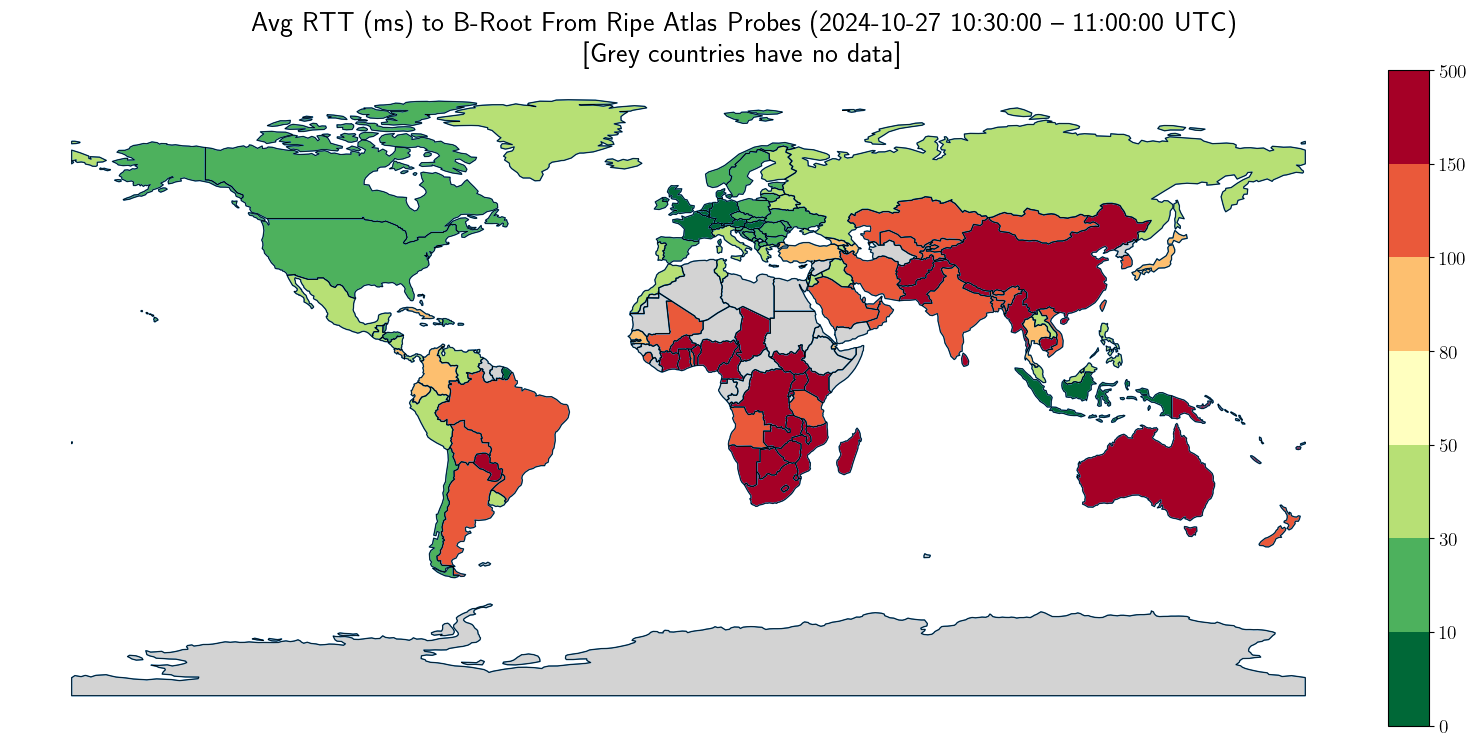

In [25]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors

# Load world map data from the downloaded shapefile
world = gpd.read_file("/tmp/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")  # Update this path

# Set the parameters to use Type 1 fonts
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['pdf.fonttype'] = 42  
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 14})

# Merge the world GeoDataFrame with your DataFrame
world = world.merge(test_df, how="left", left_on="ISO_A2_EH", right_on="country_code")

# Create a new column for avg_rt values
world['avg_rt'] = world['avg_rt'].fillna(float('nan'))  # Explicitly keep NaN for countries without data

# Define the legend labels (bins)
legend_labels = [0, 10, 30, 50, 80, 100, 150, 500]  # Include 0 to handle cases without data

# Define intervals for the color mapping
world['legend_intervals'] = pd.cut(world['avg_rt'], bins=legend_labels, include_lowest=True, labels=False)

# Set colors for regions with no data
# We'll use a separate color for NaN values (e.g., light grey)
cmap = plt.get_cmap('RdYlGn_r', len(legend_labels) - 1)
cmap.set_under('lightgrey')  # Set a color for regions with no data

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, linewidth=1)

# Plot the world map with the data, setting NaN to be transparent
world.plot(column='legend_intervals', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', 
           missing_kwds={"color": "lightgrey", "label": "No Data"})

# Create a new axes for the color bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)

# Create a custom color bar
norm = colors.BoundaryNorm(legend_labels, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Remove the coordinates from the axes
ax.axis('off')

# Add the custom color bar
fig.colorbar(sm, ticks=legend_labels, orientation='vertical', shrink=0.3, cax=cax)

# Color the oceans in light blue
ax.set_facecolor('lightblue')

# Optionally color the boundaries again if needed
world.boundary.plot(ax=ax, linewidth=0.5, color='black')

plt.title('Avg RTT (ms) to B-Root From Ripe Atlas Probes (2024-10-27 10:30:00 -- 11:00:00 UTC)\n[Grey countries have no data]',
          loc='center',fontsize=20, fontweight='bold', x=-15.8)

plt.show()


In [26]:
#now some graph sanity check

cc=['BR', 'US', 'ZA', 'JP', 'RU', 'AU', 'IN', 'NL', 'CL']
print('test_df country_code, test_df avg_rt, world ISO_A2_EH, world avg_rt')
for k in cc:
    print(test_df[test_df['country_code']==k]['country_code'].values[0],
          test_df[test_df['country_code']==k]['avg_rt'].values[0],
          world[world['ISO_A2_EH']==k]['ISO_A2_EH'].values[0],
          world[world['ISO_A2_EH']==k]['avg_rt'].values[0]
         )

test_df country_code, test_df avg_rt, world ISO_A2_EH, world avg_rt
BR 129.26810119047633 BR 129.26810119047633
US 44.429742861751826 US 44.429742861751826
ZA 175.8397155425219 ZA 175.8397155425219
JP 89.54462633451955 JP 89.54462633451955
RU 70.50730801435407 RU 70.50730801435407
AU 180.4477780548629 AU 180.4477780548629
IN 115.01301185770751 IN 115.01301185770751
NL 12.010846872082148 NL 12.010846872082148
CL 34.110152263374495 CL 34.110152263374495


# Conclusion

* There's an alterantive to dataframe language
* Duckdb enables you to write clear SQL
* We have shown an alternative engine for analysis for improved clarity

